# CoOp MobileCLIP2

Classification and retrieval with text and or visual prompts.

Markdown WIP

In [71]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


For debug:

In [72]:
#import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"         # make errors point to the right op
#os.environ["TORCH_SHOW_CPP_STACKTRACES"] = "1"

In [73]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [74]:
from dataclasses import dataclass
from typing import Tuple

@dataclass
class Config:
    #model_name: str = "ViT-B-32"
    #pretrained: str = "laion2b_s34b_b79k"
    # alternatives: "MobileCLIP2-S2", "MobileCLIP2-B", "MobileCLIP2-S3", "MobileCLIP2-S4", "MobileCLIP2-L-14"
    model_name = "MobileCLIP2-S0"
    pretrained = "dfndr2b"

    # "Donghyun99/Oxford-Flower-102", "jonathan-roberts1/EuroSAT", "tanganke/dtd"
    cls_dataset = "Donghyun99/Oxford-Flower-102"
    # "AnyModal/flickr30k"
    ret_dataset = "AnyModal/flickr30k"

    coop_text_prompt_save_path = 's0_coop_text_flickr30k.pt'
    coop_vis_prompt_save_path = 's0_coop_vis_flickr30k.pt'

    coop_version = "v0.1.1" # Prompt version for backwards compatibility

    k_per_class: int = 8 # (0 for 0shot, "all" for full dataset)

    #image_size: int = 224
    train_batch_size: int = 64
    val_batch_size: int = 64
    max_epochs: int = 3

    # Unfreeze (light finetune on top of prompt) (these constitute the "base")
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # LR split: prompts vs unfrozen base
    lr_text_prompt: float = 3e-4
    lr_vis_prompt: float = 3e-4
    lr_base: float = 1e-5
    # weight_decay
    wd_text_prompt: float = 0.0
    wd_vis_prompt: float = 0.01
    wd_base: float = 0.05

    multitask_loss_lambda: int = 0.3 # (1-lambda)*L_ret + lambda*L_cls

    text_prompt_len: int = 16
    vis_prompt_border_size: int = 64

    log_train_interval: int = 25
    log_val_interval: int = 50

    # Overfit sanity tiny subset
    #overfit_n_classes: int = 2
    #overfit_k_per_class: int = 8
    #overfit_epochs: int = 50

cfg = Config()
cfg


Config(k_per_class=8, train_batch_size=64, val_batch_size=64, max_epochs=3, unfreeze_layers=(), lr_text_prompt=0.0003, lr_vis_prompt=0.0003, lr_base=1e-05, wd_text_prompt=0.0, wd_vis_prompt=0.01, wd_base=0.05, multitask_loss_lambda=0.3, text_prompt_len=16, vis_prompt_border_size=64, log_train_interval=25, log_val_interval=50)

In [75]:
# --- Load model + preprocess ---
clip_model, train_preprocess, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)
#torchinfo.summary(clip_model)

## Load datasets

### Load classification dataset (flower102)

In [76]:
from datasets import DatasetDict

# Donghyun99/Oxford-Flower-102
# jonathan-roberts1/EuroSAT
# tanganke/dtd

cls_full_ds = datasets.load_dataset(
    cfg.cls_dataset,
    cache_dir="./hf_data",
)
#cls_full_train_ds = cls_full_ds["train"]
#cls_splits = cls_full_train_ds.train_test_split(test_size=0.1)
#cls_full_ds = DatasetDict({
#    "train": cls_splits["train"],
#    "validation": cls_splits["test"]
#})
cls_train_ds = cls_full_ds["train"]
cls_val_ds = cls_full_ds["validation"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

cls_train_ds = cls_train_ds.with_transform(transform)
cls_val_ds   = cls_val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def cls_collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    labels = torch.tensor([b["label"] for b in batch])       # [B]
    return images, labels

cls_full_train_loader = DataLoader(cls_train_ds, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=cls_collate_fn)
cls_val_loader = DataLoader(cls_val_ds, batch_size=cfg.val_batch_size, shuffle=False, collate_fn=cls_collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
cls_train_loader_overfit = DataLoader(cls_train_ds.select(range(1)), batch_size=cfg.train_batch_size, shuffle=False, collate_fn=cls_collate_fn)

cls_label_feature = cls_train_ds.features["label"]
classnames = cls_label_feature.names
num_classes = cls_label_feature.num_classes

print(classnames)
print(f"Number of classes: {len(classnames)}")
print(f"Number or training samples: {len(cls_full_train_loader.dataset)}")

[' pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 'carnation', 'garden phlox', 'love in the mist', 'mexican aster', 'alpine sea holly', 'ruby-lipped cattleya', 'cape flower', 'great masterwort', 'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil', 'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower', 'marigold', 'buttercup', 'oxeye daisy', 'common dandelion', 'petunia', 'wild pansy', 'primula', 'sunflower', 'pelargonium', 'bishop of llandaff', 'gaura', 'geranium', 'orange dahlia', 'pink-yellow dahlia?', 'c

In [77]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    #print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [78]:
if cfg.k_per_class == 0:
    # zeroshot # Todo: IMPLEMENT ME
    pass
elif cfg.k_per_class == "all":
    cls_train_loader = cls_full_train_loader
else:
    cls_train_loader = get_fewshot_dataloader(cls_full_train_loader, cfg.k_per_class)

print(f"Number of batches: {len(cls_train_loader)}, number of images: {len(cls_train_loader.dataset)}")

Number of batches: 13, number of images: 816


Dataloader with: 816 samples, 13 batches (64bs)


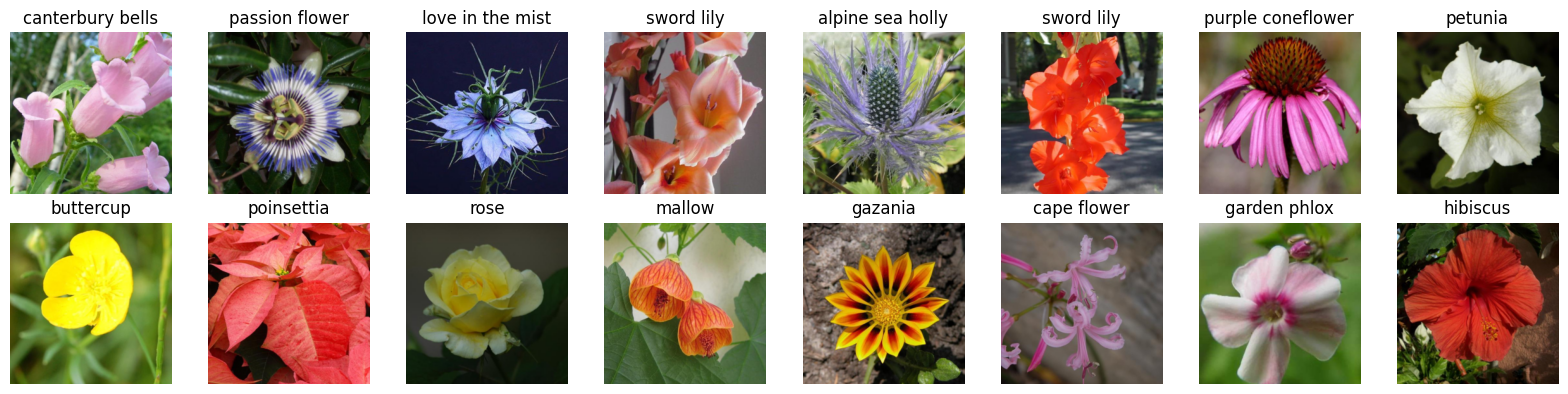

In [79]:
def preview_cls_dl(dl: DataLoader, classnames, rows: int=2, cols: int=8):
    print(f"Dataloader with: {len(dl.dataset)} samples, {len(dl)} batches ({dl.batch_size}bs)")
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].cpu().numpy().transpose(1, 2, 0)
            title = classnames[int(labels[idx])]
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

preview_cls_dl(cls_train_loader, classnames)

### Load retrieval dataset (flickr30k)

In [80]:
from datasets import DatasetDict

ret_full_ds = datasets.load_dataset(
    cfg.ret_dataset,
    cache_dir="./hf_data",
)

ret_train_ds = ret_full_ds["train"]
ret_val_ds = ret_full_ds["validation"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

ret_train_ds = ret_train_ds.with_transform(transform)
ret_val_ds   = ret_val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def ret_collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    descriptions = [b["alt_text"][0] for b in batch]
    description_ids = tokenizer(descriptions)
    #image_features = clip_model.encode_image(images)
    #image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return {
        "pixel_values": images,
        #"image_features": image_features, # Can be precomputed as the image tower is frozen
        "description": descriptions,
        "description_ids": description_ids,
    }

ret_train_loader = DataLoader(ret_train_ds, batch_size=cfg.train_batch_size, shuffle=True, collate_fn=ret_collate_fn)
ret_val_loader = DataLoader(ret_val_ds, batch_size=cfg.val_batch_size, shuffle=False, collate_fn=ret_collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

Dataloader with: 29000 samples, 454 batches (64bs)


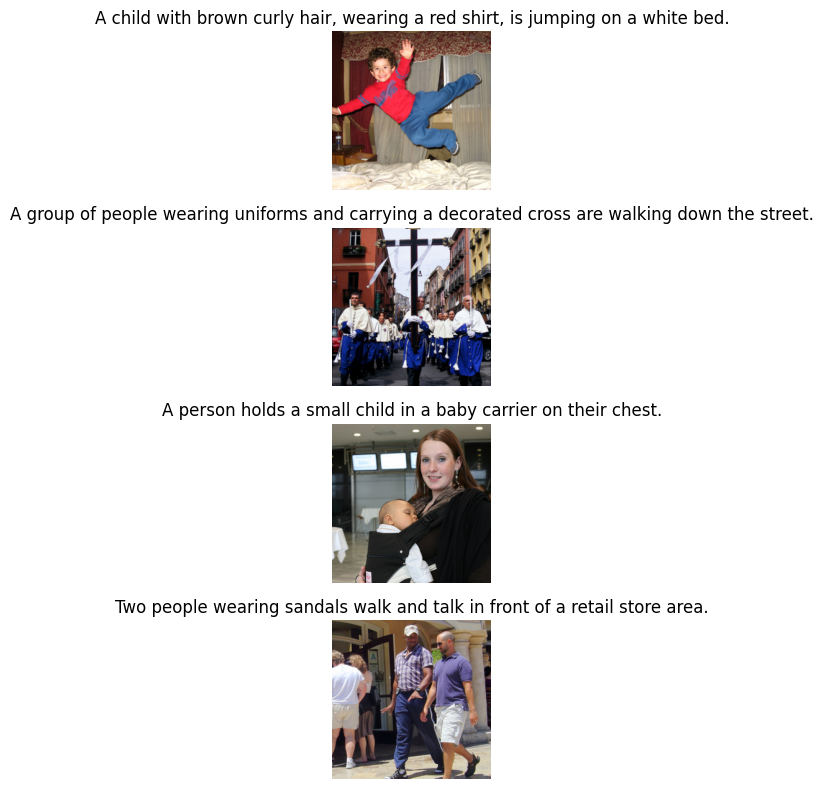

In [81]:
def preview_ret_dl(dl: DataLoader, rows: int=2, cols: int=8):
    print(f"Dataloader with: {len(dl.dataset)} samples, {len(dl)} batches ({dl.batch_size}bs)")
    batch = next(iter(dl))
    images, descriptions = batch["pixel_values"], batch["description"]
    fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            desc = descriptions[idx]
            if cols > 1:
                axs[i, j].imshow(img)
                axs[i, j].set_title(desc)
                axs[i, j].axis('off')
            else:
                axs[i].imshow(img)
                axs[i].set_title(desc)
                axs[i].axis('off')
    plt.tight_layout()
    plt.show()

preview_ret_dl(ret_train_loader, rows=4, cols=1)

## Prompt class definitions

### Hardcoded Prompt

- A prefix prompt, as a hardcoded string, which can be used similar to the trainable CoOpTextPrompt. Used for testing the zeroshot accuracy.

In [82]:
class HardcodedClsPrompt(nn.Module):
    def __init__(self, clip, classnames, prompt_prefix="A photo of a "):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        self.prompt_prefix = prompt_prefix

        prompts = [prompt_prefix + c for c in classnames]
        text_tokens = tokenizer(prompts).to(self.text_tower.token_embedding.weight.device)
        text_features = clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward(self, text_ids=None):
        return self.text_features

In [83]:
class HardcodedRetPrompt(nn.Module):
    def __init__(self, clip):
        super().__init__()
        self.clip = clip

    def forward(self, text_ids=None):
        return self.clip.encode_text(text_ids)

### CoOp Text Prompt


- class implementation of the textual prompt, which can be used direclty by the CoOpClip class for both training and inference.

- When provided to the CoOpClip, it appends to the actual prompt used(be that a classname or the image description to be retrieved).

> n_ctx = the length of the prompt in words

In [84]:
class CoOpTextPrompt(nn.Module):
    def __init__(self, clip, tokenizer, n_ctx=16, coop_version=cfg.coop_version, init_scale=0.02):
        super().__init__()
        self.coop_version = coop_version

        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def n_ctx(self):
        return self.ctx.size(0)

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward(self, text_ids, backwards_compat=True):
        eot_indices = text_ids.argmax(dim=-1)
        # text_ids: [B, L]
        B = text_ids.size(0)

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(text_ids)  # [B, L, W]

        sos = tok_emb[:, :1, :]         # [B,1,W]
        description_part = tok_emb[:, 1:, :]  # [B,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(B, -1, -1)  # [B, n_ctx, W]

        # [SOS] + [CTX...CTX] + [description tokens...]
        x = torch.cat([sos, ctx, description_part], dim=1)  # [B, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(B, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        if self.coop_version == "v0.1.0":
            n_ctx = ctx.shape[0]
        else:
            n_ctx = self.n_ctx()
        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot_indices = (eot_indices + n_ctx).clamp(max=L-1)
        text_emb = x[torch.arange(B, device=eot_indices.device), eot_indices] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

### CoOp Visual Prompt


- class implementation of the visual prompt, which can be used direclty by the CoOpClip class for both training and inference

- When provided to the CoOpClip, it adds a trainable border on top of the image.

> n_ctx = the length of the prompt in words

In [85]:
class CoOpVisPrompt(nn.Module):
    def __init__(self, clip, border_size=50, img_size=256, init_scale=0.1, coop_version=cfg.coop_version):
        super().__init__()
        self.coop_version = coop_version

        self.clip = clip
        #self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)

        #self.img_size = img_size
        #self.border_size = border_size

        mask = self.create_mask(img_size, border_size)
        self.register_buffer("mask", mask)

        self.ctx = nn.Parameter(init_scale * torch.randn(3, img_size, img_size) * self.mask)

        # Freeze clip
        for p in self.clip.parameters():
            p.requires_grad = False

    def img_size(self):
        return self.mask.shape[1]

    def border_size(self):
        row = self.mask[0][self.mask.shape[1] // 2]
        return int((row == 0).int().argmax(dim=0))

    def create_mask(self, img_size, border_size):
        mask = torch.zeros(3, img_size, img_size)
        mask[:, :border_size, :] = 1
        mask[:, -border_size:, :] = 1
        mask[:, :, :border_size] = 1
        mask[:, :, -border_size:] = 1
        return mask

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          #self.ctx.train()
          #self.text_tower.train()
        else:
          self.clip.eval()
          #self.ctx.eval()
          #self.text_tower.eval()

    def forward(self, images):
          prompt = self.ctx * self.mask
          image_features = self.clip.encode_image(images + prompt) # Broadcast over B
          return image_features

CoOpClip class

- The one which does the wiring between the clip and the two prompting methods(text/visual). The prompts can be used one at the time or combined.

In [86]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_text_prompt=None, coop_vis_prompt=None):
        super().__init__()
        self.clip = clip
        self.coop_text_prompt = coop_text_prompt
        self.coop_vis_prompt = coop_vis_prompt

        self.clip.requires_grad_(False)

        # These should already be true
        #if self.coop_text_prompt is not None:
        #    self.coop_text_prompt.requires_grad_(True)
        #if self.coop_vis_prompt is not None:
        #    self.coop_vis_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          if self.coop_text_prompt is not None:
              self.coop_text_prompt.train()
          if self.coop_vis_prompt is not None:
              self.coop_vis_prompt.train()
        else:
          self.clip.eval()
          if self.coop_text_prompt is not None:
              self.coop_text_prompt.eval()
          if self.coop_vis_prompt is not None:
              self.coop_vis_prompt.eval()

    def forward_text(self, texts):
        if self.coop_text_prompt is not None:
            text_features = self.coop_text_prompt(texts)
        else:
            text_features = self.clip.encode_text(texts)
        #text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        return text_features

    def forward_image(self, images):
        if self.coop_vis_prompt is not None:
            image_features = self.coop_vis_prompt(images)
        else:
            image_features = self.clip.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        return image_features

    def forward(self, images, texts):
        image_features = self.forward_image(images)
        text_features = self.forward_text(texts)
        ## TODO: Use the actual model trained scale
        logits = 100.0 * image_features @ text_features.T
        return logits

In [87]:
def cls_accuracy(logits, labels): # Accuracy for classification
    preds = logits.argmax(dim=1) # Per image prediction
    correct = (preds == labels).float().mean().item()
    return correct

def ret_accuracy(logits): # Accuracy for retrieval (from text to image only!)!
    preds = logits.argmax(dim=0) # Per text prediction
    labels = torch.arange(0, logits.size(0), device=logits.device)
    correct = (preds == labels).float().mean().item()
    return correct

In [88]:
class SimetricalCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, logits):
        bs = logits.size(0)
        labels = torch.arange(bs, device=logits.device)
        loss_1 = self.criterion(logits, labels)
        loss_2 = self.criterion(logits.T, labels)
        return (loss_1 + loss_2) / 2.0

In [89]:
def make_cls_report(all_loss, y_true, y_pred):
    all_loss = all_loss.detach().cpu()
    y_true = y_true.detach().cpu()
    y_pred = y_pred.detach().cpu()
    report = {
          "loss": all_loss.mean().item(),
          "accuracy": accuracy_score(y_true, y_pred),
          "macro_f1_score": f1_score(y_true, y_pred, average="macro")
    }
    return report

def make_ret_report(all_loss, logits):
    #all_loss = torch.tensor(all_loss)
    all_loss = all_loss.detach().cpu()
    ret_text_to_image_acc = ret_accuracy(logits)
    #ret_image_to_text_acc = ret_i2t_accuracy(logits)
    report = {
          "loss": all_loss.mean().item(),
          "accuracy": ret_text_to_image_acc,
    }
    return report

In [90]:
from sklearn.metrics import f1_score, accuracy_score

@torch.no_grad()
def eval_cls(model, classnames, test_loader, loss_fn, device, desc="eval", pbar=True):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
    #all_image_features = []
    class_token_ids = tokenizer(classnames).to(device)

    #print(class_token_ids)
    #return None, None

    all_loss = []
    all_true = []
    all_pred = []

    for images, labels in iterator:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        logits = model.forward(images, class_token_ids)

        loss = loss_fn(logits, labels)
        preds = logits.argmax(dim=1)

        all_loss.append(loss.item())
        all_true.append(labels.detach().cpu())
        all_pred.append(preds.detach().cpu())

        bs = labels.size(0)
        loss_sum += loss.item()
        correct += (preds == labels).sum().item()
        count += bs

        if pbar:
          acc = (correct / max(1, count)) * 100.0
          iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

    all_loss = torch.tensor(all_loss)
    all_true = torch.cat(all_true)
    all_pred = torch.cat(all_pred)

    report = make_cls_report(all_loss, all_true, all_pred)

    #report = classification_report(all_true, all_pred, output_dict=True)
    #report["avg_loss"] = avg_loss

    return report

@torch.no_grad()
def eval_ret(model, test_loader, loss_fn, device, desc="eval", pbar=True):
    model.eval()
    loss_sum, correct, count = 0.0, 0, 0
    iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
    all_image_features = []
    all_text_features = []
    for batch in iterator:
        images, description_ids = batch["pixel_values"], batch["description_ids"]
        images = images.to(device, non_blocking=True)
        description_ids = description_ids.to(device, non_blocking=True)

        image_features = model.forward_image(images)
        text_features = model.forward_text(description_ids)

        all_image_features.append(image_features)
        all_text_features.append(text_features)

    # For the true accuracy, it is needed to retrieve the text from all the images
    all_image_features = torch.cat(all_image_features, dim=0)
    all_text_features = torch.cat(all_text_features, dim=0)

    logits = all_image_features @ all_text_features.T

    loss = loss_fn(logits)
    acc = ret_accuracy(logits)

    report = make_ret_report(loss, logits)

    return report

In [91]:
def make_optimizer_params(model, cfg):
    params = []
    if model.coop_text_prompt is not None and model.coop_text_prompt.ctx is not None:
        params.append({
            "params": model.coop_text_prompt.ctx,
            "lr": cfg.lr_text_prompt,
            "weight_decay": cfg.wd_text_prompt,
        })
    if model.coop_vis_prompt is not None and model.coop_vis_prompt.ctx is not None:
        params.append({
            "params": model.coop_vis_prompt.ctx,
            "lr": cfg.lr_vis_prompt,
            "weight_decay": cfg.wd_vis_prompt,
        })
    base_params = [p for p in model.clip.parameters() if p.requires_grad]
    if len(base_params) > 0:
        params.append({
            "params": base_params,
            "lr": cfg.lr_base,
            "weight_decay": cfg.wd_base,
        })
    return params

## Training loop definitions

### There follows 3 training loops, classification, retrieval and multitask(both).

The contain history logging train and val accuracy and loss.

Important params from the config:

- max_epochs (Early stopping not implemented)
- lr_text_prompt
- lr_vis_prompt
- lr_base
- log_train_interval
> Number of steps (batch forwards) neccesary for each train log
- log_val_interval
> Number of steps neccesary for each training (**Note:** that the validation is being done on the full validation split, so it might take a lot of time on some datasets. val_loader can be manually adjusted before to address this issue).

### Train classifier

In [92]:
def train_cls(
    model, classnames, train_loader, val_loader, config, device="cpu"
):
    model.to(device)
    class_token_ids = tokenizer(classnames).to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        "train": {
            "time": [], "report": [],
        },
        "val": {
            "time": [], "report": [],
        }
    }

    model.eval()
    with torch.no_grad():
        val_report = eval_cls(
            model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val']['time'].append(t)
        history['val']['report'].append(val_report)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%  val_f1_score={val_report["macro_f1_score"]}"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images, class_token_ids)
            loss = loss_fn(logits, labels)

            train_report = make_cls_report(loss, labels, logits.argmax(dim=-1))

            history["train"]['time'].append(t)
            history["train"]["report"].append(train_report)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_f1={val_report["macro_f1_score"]} %"""
                )

            if log_val_interval and t % log_val_interval == 0:
                val_report = eval_cls(
                     model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history["val"]['time'].append(t)
                history["val"]['report'].append(val_report)
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  macro_f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_macro_f1={val_report["macro_f1_score"]} %"""
                )
        last_train_reports = history["train"]['report'][-min(len(train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])

        if log_val_interval:
            avg_val_loss = history["val"]['report'][-1]["loss"]
            avg_val_acc = history["val"]["report"][-1]["accuracy"]
            tqdm.write(
                f"Epoch {epoch:03d}: "
                f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
                f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
            )
        else:
            tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
        )

    if log_val_interval and t > 0:
        val_report = eval_cls(
              model, classnames, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history["val"]['time'].append(t)
        history["val"]['report'].append(val_report)
    return history

### Train retrieval

In [93]:
def train_ret(
    model, train_loader, val_loader, config, device="cpu",
):
    model.to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    loss_fn = SimetricalCrossEntropyLoss()

    t = 0 # current_time_step

    history = {
        "train": {
            "time": [], "report": [],
        },
        "val": {
            "time": [], "report": [],
        }
    }

    model.eval()
    with torch.no_grad():
        val_report = eval_ret(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history["val"]["time"].append(t)
        history["val"]["report"].append(val_report)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, batch in enumerate(iterator, start=1):
            images, description_ids = batch["pixel_values"], batch["description_ids"]
            images = images.to(device, non_blocking=True)
            description_ids = description_ids.to(device, non_blocking=True)

            logits = model(images, description_ids)
            loss = loss_fn(logits)

            train_report = make_ret_report(loss, logits)

            history["train"]["time"].append(t)
            history["train"]["report"].append(train_report)

            #history['train_time'].append(t)
            #history['train_loss'].append(loss.item())
            #history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_f1={val_report["macro_f1_score"]} %"""
                )

            if log_val_interval and t % log_val_interval == 0:
                val_report = eval_ret(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history["val"]['time'].append(t)
                history["val"]['report'].append(val_report)
                iterator.set_postfix_str(
                    f"""loss={train_report["loss"]:.4f}  acc={train_report["accuracy"]*100:.2f}  macro_f1={train_report["macro_f1_score"]} \n"
                    val_loss={val_report["loss"]:.4f}  val_acc={val_report["accuracy"]*100:.2f} val_macro_f1={val_report["macro_f1_score"]} %"""
                )

        last_train_reports = history["train"]['report'][-min(len(train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])
        avg_val_loss = history["val"]['report'][-1]["loss"]
        avg_val_acc = history["val"]["report"][-1]["accuracy"]


        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    if t > 0:
        val_report = eval_ret(
              model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
        )
        history["val"]['time'].append(t)
        history["val"]['report'].append(val_report)

    return history

### Train multitask (cls + ret)

Not well tested.

The loss for the multitask is similar to a distil loss.

`L_total = (1-lambda)*L_ret + lambda*L_cls`


During the main loop, the loop over the retrieval dataset, we also evaluate the classification loss by getting the next batch from the infinte loader.
This feels like a hack, using something like zip might be cleaner.

After testing some more and find this stable, consider having multiple cls datasets at the same time (the loss being the mean of the sublosses)

In [94]:
from copy import deepcopy

def infinite_loader(dataloader):
    while True:
        for batch in dataloader:
            yield batch

def train_multitask(
    model, ret_train_loader, ret_val_loader, classnames,
    cls_train_loader, cls_val_loader, config, device="cpu",
):
    model.to(device)
    class_token_ids = tokenizer(classnames).to(device)

    epochs = config.max_epochs
    #batch_size = config.batch_size
    log_train_interval = config.log_train_interval
    log_val_interval = config.log_val_interval
    loss_lambda = config.multitask_loss_lambda

    inf_cls_train_loader = infinite_loader(cls_train_loader)
    #inf_cls_val_loader = infinite_loader(cls_val_loader)

    params = make_optimizer_params(model, config)
    optimizer = torch.optim.AdamW(params)
    ret_loss_fn = SimetricalCrossEntropyLoss()
    cls_loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    per_task_empty_history = {
        "train": {"time": [], "report": []},
        "val": {"time": [], "report": []},
    }

    history = {
        "ret": deepcopy(per_task_empty_history),
        "cls": deepcopy(per_task_empty_history),
    }

    model.eval()
    with torch.no_grad():
        task = "ret"
        ret_val_report = eval_ret(
            model, ret_val_loader, loss_fn=ret_loss_fn, device=device, desc="valid", pbar=True
        )
        history[task]["val"]["time"].append(t)
        history[task]["val"]["report"].append(ret_val_report)

        task = "cls"
        cls_val_report = eval_cls(
            model, classnames, cls_val_loader, loss_fn=cls_loss_fn, device=device, desc="valid", pbar=True
        )
        history[task]["val"]["time"].append(t)
        history[task]["val"]["report"].append(cls_val_report)


        tqdm.write(
            f"Before training: "
            f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            ret_train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, batch in enumerate(iterator, start=1):
            images, description_ids = batch["pixel_values"], batch["description_ids"]
            images = images.to(device, non_blocking=True)
            description_ids = description_ids.to(device, non_blocking=True)

            logits = model(images, description_ids)
            ret_loss = ret_loss_fn(logits)
            #ret_acc = ret_accuracy(logits)

            task = "ret"
            ret_train_report = make_ret_report(ret_loss, logits)
            history[task]["train"]["time"].append(t)
            history[task]["train"]["report"].append(ret_train_report)

            images, labels = next(inf_cls_train_loader)
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images, class_token_ids)
            cls_loss = cls_loss_fn(logits, labels)

            task = "cls"
            cls_train_report = make_cls_report(cls_loss, labels, logits.argmax(-1))
            history[task]["train"]["time"].append(t)
            history[task]["train"]["report"].append(cls_train_report)

            loss = (1 - loss_lambda) * ret_loss + loss_lambda * cls_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
                )

            if log_val_interval and t % log_val_interval == 0:
                ret_val_report = eval_ret(
                     model, ret_val_loader, loss_fn=ret_loss_fn, device=device, desc="valid", pbar=False
                )
                task = "ret"
                history[task]["val"]["time"].append(t)
                history[task]["val"]["report"].append(ret_val_report)

                cls_val_report = eval_cls(
                     model, classnames, cls_val_loader, loss_fn=cls_loss_fn, device=device, desc="valid", pbar=False
                )
                task = "cls"
                history[task]["val"]["time"].append(t)
                history[task]["val"]["report"].append(cls_val_report)
                iterator.set_postfix_str(
                    f"""ret_val_loss={ret_val_report["loss"]:.4f}  ret_val_acc={ret_val_report["accuracy"]*100:.2f}%\n
                    cls_val_loss={cls_val_report["loss"]:.4f}  cls_val_acc={cls_val_report["accuracy"]*100:.2f}%"""
                )

        task = "ret"
        last_train_reports = history[task]["train"]['report'][-min(len(train_loader),100):]
        avg_train_loss = np.mean([report["loss"] for report in last_train_reports])
        avg_train_acc = np.mean([report["accuracy"] for report in last_train_reports])
        avg_val_loss = history[task]["val"]['report'][-1]["loss"]
        avg_val_acc = history[task]["val"]["report"][-1]["accuracy"]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [114]:
def plot_metric(ax, history, metric):
    train_metric_list = [report[metric] for report in history["train"]["report"]]
    assert len(history["train"]["time"]) == len(train_metric_list)

    ax.plot(history["train"]["time"], train_metric_list, label='train', linewidth=1.5)

    if 'val' in history and len(history["val"]) and len(history["val"]["report"]) and metric in history["val"]["report"][0]:
        val_metric_list = [report[metric] for report in history["val"]["report"]]
        ax.plot(history["val"]["time"], val_metric_list, label='val', linewidth=1.2, marker='o', markersize=3)

    ax.set_xlabel('Time'); ax.set_ylabel(metric.capitalize()); ax.set_title(metric.capitalize()); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    plot_metric(axes[0], history, "loss")
    plot_metric(axes[1], history, "accuracy")

    plt.show()

## Zero shot

In [96]:
hardcoded_text_prompt = HardcodedClsPrompt(
    clip=clip_model,
    classnames=classnames,
    prompt_prefix="A photo of a ",
)

zeroshotclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=hardcoded_text_prompt,
).to(device)

In [97]:
eval_cls(
    model=zeroshotclip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    loss_fn=nn.CrossEntropyLoss(),
    device=device
)

eval:   0%|          | 0/16 [00:00<?, ?it/s]

{'loss': 1.51462984085083,
 'accuracy': 0.7490196078431373,
 'macro_f1_score': 0.7109677485172237}

In [98]:
hardcoded_text_prompt = HardcodedRetPrompt(
    clip=clip_model,
)

zeroshotclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=hardcoded_text_prompt,
).to(device)

In [99]:
eval_ret(
    model=zeroshotclip_model,
    test_loader=ret_val_loader,
    loss_fn=SimetricalCrossEntropyLoss(),
    device=device
)

eval:   0%|          | 0/16 [00:00<?, ?it/s]

{'loss': 4.992420673370361, 'accuracy': 0.7475345134735107}

### Create the actual prompts and the composed model.

- Create new context optimizable prompts (initialized with random values)
- Test before training (should be worse than the zeroshot in general)
- Train for cls/ret/both
- Test again

In [100]:
#coop_text_prompt = CoOpTextPrompt(
#    clip=clip_model,
#    tokenizer=tokenizer,
#    n_ctx=cfg.text_prompt_len,
#)

#coop_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_8.pt")
#coop_text_prompt.ctx.requires_grad = False

coop_vis_prompt = CoOpVisPrompt(
    clip=clip_model,
    init_scale=0.02,
    #border_size=cfg.vis_prompt_border_size,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=None,
    coop_vis_prompt=coop_vis_prompt,
).to(device)

In [101]:
eval_cls(
    model=coopclip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
)

eval:   0%|          | 0/16 [00:00<?, ?it/s]

{'loss': 14.520366668701172,
 'accuracy': 0.6872549019607843,
 'macro_f1_score': 0.6703836799863138}

In [102]:
eval_ret(
    model=coopclip_model,
    test_loader=ret_val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
)

eval:   0%|          | 0/16 [00:00<?, ?it/s]

{'loss': 5.005939483642578, 'accuracy': 0.7307692170143127}

In [103]:
cfg.log_val_interval = len(cls_train_loader) * cfg.max_epochs // 5
cfg.log_val_interval

7

In [104]:
cfg.lr_vis_prompt = 3e-4

In [116]:
#cfg.log_val_interval = 100

cfg.max_epochs = 30
cfg.lr_vis_prompt = 3e-4
cfg.log_val_interval = 100
print(cfg)

history = train_cls(
    coopclip_model,
    classnames=classnames,
    train_loader=cls_train_loader,
    val_loader=cls_val_loader,
    config=cfg,
    device=device,
)

Config(k_per_class=8, train_batch_size=64, val_batch_size=64, max_epochs=30, unfreeze_layers=(), lr_text_prompt=0.0003, lr_vis_prompt=0.0003, lr_base=1e-05, wd_text_prompt=0.0, wd_vis_prompt=0.01, wd_base=0.05, multitask_loss_lambda=0.3, text_prompt_len=16, vis_prompt_border_size=64, log_train_interval=25, log_val_interval=100)


valid:   0%|          | 0/16 [00:00<?, ?it/s]

Before training: val_loss=14.7275  val_acc=65.29%  val_f1_score=0.635431061441598


Epoch 1/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 001: train_loss=10.2533  train_acc=66.63%  val_loss=14.7275  val_acc=65.29%


Epoch 2/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 002: train_loss=8.6660  train_acc=72.08%  val_loss=14.7275  val_acc=65.29%


Epoch 3/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 003: train_loss=7.5981  train_acc=74.20%  val_loss=14.7275  val_acc=65.29%


Epoch 4/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 004: train_loss=6.7889  train_acc=77.04%  val_loss=14.7275  val_acc=65.29%


Epoch 5/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 005: train_loss=6.1686  train_acc=79.37%  val_loss=14.7275  val_acc=65.29%


Epoch 6/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 006: train_loss=5.6605  train_acc=80.97%  val_loss=14.7275  val_acc=65.29%


Epoch 7/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 007: train_loss=5.2324  train_acc=82.05%  val_loss=14.7275  val_acc=65.29%


Epoch 8/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 008: train_loss=4.8756  train_acc=84.05%  val_loss=13.7059  val_acc=68.04%


Epoch 9/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 009: train_loss=4.5766  train_acc=85.02%  val_loss=13.7059  val_acc=68.04%


Epoch 10/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 010: train_loss=4.3063  train_acc=85.86%  val_loss=13.7059  val_acc=68.04%


Epoch 11/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 011: train_loss=4.0597  train_acc=87.30%  val_loss=13.7059  val_acc=68.04%


Epoch 12/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 012: train_loss=3.8642  train_acc=87.70%  val_loss=13.7059  val_acc=68.04%


Epoch 13/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 013: train_loss=3.6928  train_acc=88.18%  val_loss=13.7059  val_acc=68.04%


Epoch 14/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 014: train_loss=3.5284  train_acc=88.78%  val_loss=13.7059  val_acc=68.04%


Epoch 15/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 015: train_loss=3.3692  train_acc=89.30%  val_loss=13.7059  val_acc=68.04%


Epoch 16/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 016: train_loss=3.2124  train_acc=89.90%  val_loss=13.5880  val_acc=68.04%


Epoch 17/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 017: train_loss=3.0643  train_acc=90.38%  val_loss=13.5880  val_acc=68.04%


Epoch 18/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 018: train_loss=2.9302  train_acc=91.11%  val_loss=13.5880  val_acc=68.04%


Epoch 19/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 019: train_loss=2.8169  train_acc=91.11%  val_loss=13.5880  val_acc=68.04%


Epoch 20/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 020: train_loss=2.7056  train_acc=91.23%  val_loss=13.5880  val_acc=68.04%


Epoch 21/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 021: train_loss=2.5969  train_acc=91.23%  val_loss=13.5880  val_acc=68.04%


Epoch 22/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 022: train_loss=2.5037  train_acc=91.59%  val_loss=13.5880  val_acc=68.04%


Epoch 23/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 023: train_loss=2.4161  train_acc=91.95%  val_loss=13.5880  val_acc=68.04%


Epoch 24/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 024: train_loss=2.3292  train_acc=92.07%  val_loss=13.5170  val_acc=67.65%


Epoch 25/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 025: train_loss=2.2534  train_acc=92.07%  val_loss=13.5170  val_acc=67.65%


Epoch 26/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 026: train_loss=2.1728  train_acc=92.39%  val_loss=13.5170  val_acc=67.65%


Epoch 27/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 027: train_loss=2.1007  train_acc=92.55%  val_loss=13.5170  val_acc=67.65%


Epoch 28/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 028: train_loss=2.0258  train_acc=92.43%  val_loss=13.5170  val_acc=67.65%


Epoch 29/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 029: train_loss=1.9566  train_acc=92.55%  val_loss=13.5170  val_acc=67.65%


Epoch 30/30 | train:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch 030: train_loss=1.8845  train_acc=92.91%  val_loss=13.5170  val_acc=67.65%


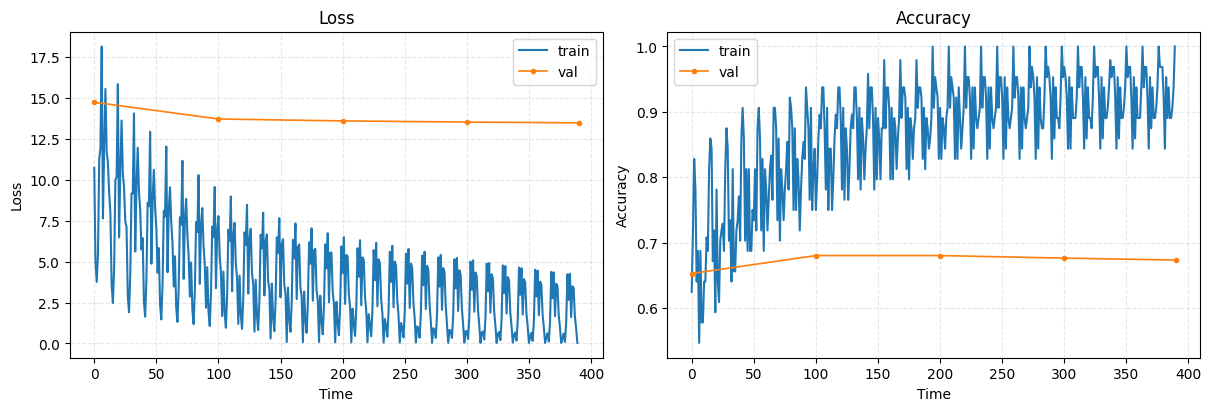

In [117]:
plot_history(history)

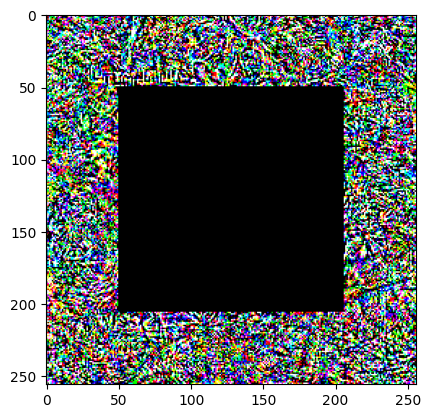

In [107]:
plt.imshow(coop_vis_prompt.ctx.detach().cpu().numpy().transpose(1, 2, 0)*50)

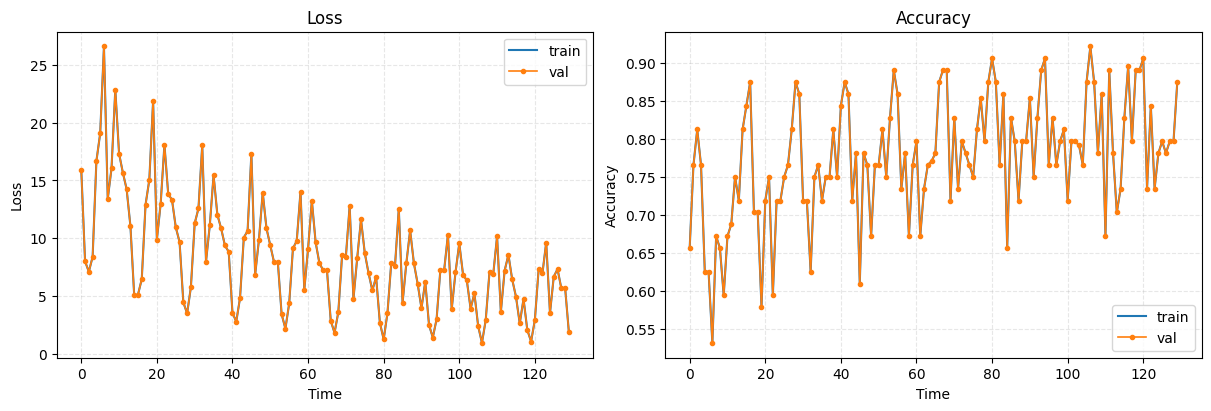

In [108]:
plot_history(history)

In [111]:
history = train_ret(
    model=coopclip_model,
    train_loader=ret_train_loader,
    val_loader=ret_val_loader,
    config=cfg,
    device=device,
)

valid:   0%|          | 0/16 [00:00<?, ?it/s]

Before training: val_loss=5.1280  val_acc=66.77%


Epoch 1/10 | train:   0%|          | 0/454 [00:00<?, ?it/s]

KeyError: 'macro_f1_score'

In [ ]:
history = train_multitask(
    model=coopclip_model,
    ret_train_loader=ret_train_loader,
    ret_val_loader=ret_val_loader,
    classnames=classnames,
    cls_train_loader=cls_train_loader,
    cls_val_loader=cls_val_loader,
    config=cfg,
    device=device,
)

In [ ]:
plot_history(history["ret"])

In [ ]:
plot_history(history["cls"])

Saving prompts to load them latter for further testing and comparisons.

In [ ]:
import torch, hashlib, json
from typing import Literal


def save_coop_prompt(prompt_type: Literal["text", "vis"], coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    if prompt_type == "text":
        ctx = coop_prompt.ctx.detach().cpu()
        n_ctx = ctx.shape[0]
        payload = {
            "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
            "meta": {
                "coop_version": coop_prompt.coop_version,
                "prompt_type": prompt_type,
                "model_name": model_name,
                "pretrained": pretrained,
                "n_ctx": int(n_ctx),
            }
        }
    elif prompt_type == "vis":
        ctx = coop_prompt.ctx.detach().cpu()
        border_size = coop_prompt.border_size()
        payload = {
            "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
            "meta": {
                "coop_version": coop_prompt.coop_version,
                "prompt_type": prompt_type,
                "model_name": model_name,
                "pretrained": pretrained,
                "border_size": int(border_size),
            }
        }
    torch.save(payload, path)


In [ ]:
save_coop_prompt("text", coopclip_model.coop_text_prompt, cfg.coop_text_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained)

save_coop_prompt("vis", coopclip_model.coop_vis_prompt, cfg.coop_vis_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained)

In [ ]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  prompt_type = payload["meta"].get("prompt_type", "text") # Backwards compatibility
  ctx = payload["ctx"]
  model_name = payload["meta"]["model_name"]
  coop_version = payload["meta"].get("coop_version", "v0.1.0")
  if cfg.model_name != model_name:
      raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.model_name: '{cfg.model_name}'")
  if prompt_type == "text":
      n_ctx = payload["meta"]["n_ctx"]
      coop_prompt = CoOpTextPrompt(clip, tokenizer, n_ctx, coop_version=coop_version)
  elif prompt_type == "vis":
      border_size = payload["meta"]["border_size"]
      coop_prompt = CoOpVisPrompt(clip, coop_version=coop_version)
  with torch.no_grad():
      coop_prompt.ctx.copy_(ctx)

  print(f"Loaded {prompt_type.upper()} prompt for {model_name}.")

  return coop_prompt

In [ ]:
loaded_text_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_text_prompt_save_path)
loaded_vis_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_vis_prompt_save_path)

Quick sanity check for the loaded prompts (check whether or not the cls and ret accuracies are persistent)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=loaded_text_prompt,
    coop_vis_prompt=loaded_vis_prompt,
).to(device)

#loss, acc = evaluate_classifier(
#    model=loaded_coopclip_model,
#    classnames=classnames,
#    test_loader=cls_val_loader,
#    device=device,
#    loss_fn=nn.CrossEntropyLoss(),
#    desc="Testing trained CoOpClip on full val",
#    pbar=True
#)
#print(f"Accuracy for classification for the loaded model: {acc}")

loss, acc = evaluate_retrieval(
    model=loaded_coopclip_model,
    test_loader=ret_val_loader,
    device=device,
    loss_fn=SimetricalCrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for retrieval for the loaded model: {acc}")

## Compute once, retrieve forever!!

In [ ]:
from PIL import Image

@torch.no_grad()
def precompute_image_features(model, loader):
  loaded_coopclip_model.eval()
  image_features = []
  for batch in loader:
    images = batch["pixel_values"]
    images = images.to(device, non_blocking=True)
    image_features.append(loaded_coopclip_model.forward_image(images).detach().cpu())
  image_features = torch.cat(image_features, dim=0)
  return image_features

val_image_features = precompute_image_features(loaded_coopclip_model, ret_val_loader)
#plt.imshow(best_image[0].permute(1, 2, 0))

In [ ]:
@torch.no_grad()
def retrieve(model, text, image_features, top_k=1):
    image_features = image_features.to(device)
    model.to(device)
    model.eval()

    text_features = model.forward_text(tokenizer(text).to(device))

    logits = image_features @ text_features.T
    logits = logits.squeeze(1)
    preds = (-logits).argsort(dim=0)[:top_k].detach().cpu()
    scores = logits[preds].detach().cpu()

    return preds, scores

top_k = 3
prompt = "A man at the seaside"

preds, scores = retrieve(loaded_coopclip_model, prompt, val_image_features, top_k=top_k)

for i in range(top_k):
    image = torch.as_tensor(ret_val_loader.dataset[preds[i].item()]['pixel_values'])
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Score: {scores[i]}")
    plt.show()

Clean GPU memory, cuz for whatever reason, images sometimes stick on the gpu even after training

In [ ]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

In [ ]:
import torch, math

def list_cuda_tensors(namespace=None):
    if namespace is None:
        namespace = globals()
    rows = []
    for name, obj in list(namespace.items()):
        if isinstance(obj, torch.Tensor) and obj.is_cuda:
            mb = obj.numel() * obj.element_size() / (1024**2)
            rows.append((name, tuple(obj.shape), str(obj.dtype), str(obj.device), f"{mb:.1f} MB"))
    rows.sort(key=lambda r: float(r[-1].split()[0]), reverse=True)
    for r in rows:
        print(r)
list_cuda_tensors()

In [ ]:
import gc, torch
# drop any live refs
_ = images = image_features = logits = pred = None
gc.collect()
torch.cuda.empty_cache()


### DRAFTS:


In [ ]:
from PIL import Image
image = Image.open("flower.jpg")

p_image = preprocess(image)
p_image.shape
#plt.imshow(preprocess(image))

In [ ]:
#flower102_text_prompt = load_coop_prompt(clip_model, tokenizer, "s0_coop_flower102_all.pt")
flower102_vis_prompt = CoOpVisPrompt(
    clip=clip_model,
    init_scale=0,
)

flower102_clip_model = CoOpClip(
    clip=clip_model,
    coop_text_prompt=None,
    coop_vis_prompt=flower102_vis_prompt,
).to(device)

In [ ]:
_ = flower102_text_prompt.forward(tokenizer(classnames).to(device)).detach().cpu()

In [ ]:
report = eval_cls(
    model=flower102_clip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
report
#print(f"Accuracy for classification: {acc}")

Testing with overfit for easy debug.

In [ ]:
cls_train_loader_overfit = DataLoader(cls_train_ds.select(range(400)), batch_size=cfg.train_batch_size, shuffle=False, collate_fn=cls_collate_fn)

In [ ]:
print(len(cls_train_loader.dataset), len(cls_train_loader_overfit.dataset))

In [ ]:
cfg.max_epochs = 30
cfg.lr_vis_prompt = 10e-4
cfg.log_val_interval = 100
print(cfg)

history = train_cls(
    flower102_clip_model,
    classnames=classnames,
    train_loader=cls_train_loader,
    val_loader=cls_train_loader_overfit,
    config=cfg,
    device=device,
)

In [ ]:
plot_history(history)

In [ ]:
plt.imshow(flower102_clip_model.coop_vis_prompt.ctx.detach().cpu().numpy().transpose(1, 2, 0)*100)

In [ ]:
loss, acc = evaluate_classifier(
    model=flower102_clip_model,
    classnames=classnames,
    test_loader=cls_val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for classification: {acc}")

In [ ]:
def cached_transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    img_emb = model.forward_images(preprocess(imgs))
    batch["image_embedding"] = img_emb
    return batch

def cached_collate_fn(batch):
    img_emb = torch.stack([b["image_embedding"] for b in batch])  # [B,3,H,W]
    descriptions = [b["alt_text"][0] for b in batch]
    description_ids = tokenizer(descriptions)
    #image_features = clip_model.encode_image(images)
    #image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    return {
        "image_embedding": img_emb,
        #"image_features": image_features, # Can be precomputed as the image tower is frozen
        "description": descriptions,
        "description_ids": description_ids,
    }
